In [61]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm

MASTER_CSV = "../1_data/historical_prices.csv"
OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TABLE_DIR = os.path.join(OUT_DIR, "tables")

TRADING_DAYS = 252
ROLL_3M = 63
ROLL_1Y = 252

REBAL_FEE_PCT = 0.003
REBAL_FEE_RATE = REBAL_FEE_PCT / 100.0

# Crypto assets available
CRYPTO_COLS = ["BTC-USD", "ETH-USD", "BNB-USD", "SOL-USD", "XRP-USD", "DOGE-USD", "SHIB-USD"]

FF_COLS = ["Mkt-RF", "SMB", "HML", "RF"]


def ensure_dirs():
    """Make output folders."""
    os.makedirs(FIG_DIR, exist_ok=True)
    os.makedirs(TABLE_DIR, exist_ok=True)


def read_master_csv(path: str) -> pd.DataFrame:
    """Read master CSV and parse DATE index"""
    df = pd.read_csv(path)

    if "DATE" not in df.columns:
        df.rename(columns={df.columns[0]: "DATE"}, inplace=True)

    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
    bad = df["DATE"].isna().mean()
    if bad > 0.2:
        df["DATE"] = pd.to_datetime(df["DATE"], format="%m/%d/%Y", errors="coerce")

    df = df.dropna(subset=["DATE"]).set_index("DATE").sort_index()

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df


def price_returns(prices: pd.DataFrame) -> pd.DataFrame:
    """Simple returns from price levels"""
    return prices.pct_change(fill_method=None)


def to_decimal_ff(ff: pd.DataFrame) -> pd.DataFrame:
    """FF daily factors are in percent; convert to decimal"""
    return ff / 100.0


def cum_growth(r: pd.Series) -> pd.Series:
    """$1 growth curve."""
    return (1.0 + r.fillna(0.0)).cumprod()


def drawdown_curve(r: pd.Series) -> pd.Series:
    """Drawdown from running peak"""
    g = cum_growth(r)
    peak = g.cummax()
    return g / peak - 1.0


def cagr(r: pd.Series) -> float:
    """CAGR using actual calendar time"""
    r = r.dropna()
    if r.empty:
        return np.nan
    total = (1 + r).prod()
    if total <= 0:
        return np.nan
    years = (r.index[-1] - r.index[0]).days / 365.25
    if years <= 0:
        return np.nan
    result = total ** (1 / years) - 1
    # Check for inf or very large values
    if np.isinf(result) or abs(result) > 100:
        return np.nan
    return result


def ann_vol(r: pd.Series, freq: int = TRADING_DAYS) -> float:
    """Annualized vol"""
    return r.dropna().std(ddof=1) * np.sqrt(freq)


def sharpe(r: pd.Series, rf_daily: pd.Series) -> float:
    """Annualized Sharpe vs daily rf"""
    x = (r - rf_daily).dropna()
    if x.std(ddof=1) == 0 or x.empty:
        return np.nan
    return (x.mean() / x.std(ddof=1)) * np.sqrt(TRADING_DAYS)


def downside_dev(excess: pd.Series) -> float:
    """Annualized downside deviation"""
    d = excess.copy()
    d[d > 0] = 0
    if d.dropna().empty:
        return np.nan
    return np.sqrt((d**2).mean()) * np.sqrt(TRADING_DAYS)


def sortino(r: pd.Series, rf_daily: pd.Series) -> float:
    """Annualized Sortino vs daily rf"""
    ex = (r - rf_daily).dropna()
    dd = downside_dev(ex)
    if dd == 0 or np.isnan(dd) or ex.empty or np.isinf(dd):
        return np.nan
    result = ex.mean() * TRADING_DAYS / dd
    if np.isinf(result) or abs(result) > 1000:
        return np.nan
    return result


def max_drawdown(r: pd.Series) -> float:
    """Max drawdown"""
    return drawdown_curve(r).min()


def calmar(r: pd.Series) -> float:
    """CAGR / |MaxDD|"""
    md = abs(max_drawdown(r))
    cagr_val = cagr(r)
    if md > 0 and not np.isnan(cagr_val) and not np.isinf(cagr_val):
        result = cagr_val / md
        if np.isinf(result) or abs(result) > 1000:
            return np.nan
        return result
    return np.nan


def win_rate(r: pd.Series) -> float:
    """Share of positive return days."""
    r = r.dropna()
    return (r > 0).mean() if not r.empty else np.nan


def perf_table(returns: pd.DataFrame, rf_daily: pd.Series) -> pd.DataFrame:
    """Metrics table for many return series."""
    out = []
    for c in returns.columns:
        r = returns[c].dropna()
        if r.empty:
            continue
        # Calculate all metrics
        cagr_val = cagr(r)
        annvol_val = ann_vol(r)
        sharpe_val = sharpe(r, rf_daily)
        sortino_val = sortino(r, rf_daily)
        maxdd_val = max_drawdown(r)
        calmar_val = calmar(r)
        winrate_val = win_rate(r)
        skew_val = r.skew()
        kurt_val = r.kurtosis()
        
        # Replace inf and very large values with nan
        def clean_val(v):
            if pd.isna(v):
                return np.nan
            if np.isinf(v) or (isinstance(v, float) and abs(v) > 1e6):
                return np.nan
            return v
        
        out.append({
            "Series": c,
            "CAGR": clean_val(cagr_val),
            "AnnVol": clean_val(annvol_val),
            "Sharpe": clean_val(sharpe_val),
            "Sortino": clean_val(sortino_val),
            "MaxDD": clean_val(maxdd_val),
            "Calmar": clean_val(calmar_val),
            "WinRate": clean_val(winrate_val),
            "Skew": clean_val(skew_val),
            "Kurt": clean_val(kurt_val)
        })
    df = pd.DataFrame(out).set_index("Series")
    # Sort by Sharpe, handling NaN values
    df = df.sort_values("Sharpe", ascending=False, na_position='last')
    return df


def normalize_weights(w: dict) -> pd.Series:
    """Weights -> Series, sums to 1."""
    s = pd.Series(w, dtype=float)
    s = s[s != 0].dropna()
    s = s / s.sum()
    return s


def filter_weights_to_available(weights: pd.Series, available_cols: list[str]) -> pd.Series:
    """Drop missing assets and renormalize."""
    w = weights[weights.index.isin(available_cols)].copy()
    if w.empty:
        raise KeyError("None of the assets in this portfolio exist in the dataset.")
    return w / w.sum()


def simulate_buy_and_hold(prices: pd.DataFrame, weights: pd.Series, initial_value: float = 1.0):
    """Buy-and-hold, no rebalancing"""
    # Start on first date
    px = prices[weights.index].copy()
    
    # Ensure no zero or negative prices
    if (px <= 0).any().any():
        print("Warning: Zero or negative prices detected in buy-and-hold simulation")
        px[px <= 0] = np.nan
        px = px.ffill().bfill()
    
    start_px = px.iloc[0]
    
    # Check for zero prices that would cause division by zero
    zero_prices = start_px[start_px <= 0]
    if len(zero_prices) > 0:
        raise ValueError(f"Zero prices detected for: {zero_prices.index.tolist()}")

    # Shares fixed for fully buy-and-hold
    holdings = (initial_value * weights) / start_px
    value = (px * holdings).sum(axis=1)
    ret = value.pct_change(fill_method=None)
    ret.iloc[0] = 0.0  # First return is 0
    
    # Remove inf values
    ret = ret.replace([np.inf, -np.inf], np.nan)

    # Weight drift 
    drift_w = (px * holdings).div(value, axis=0)
    drift_w = drift_w.replace([np.inf, -np.inf], np.nan)

    return value, ret, drift_w


def simulate_rebalanced(
    prices: pd.DataFrame,
    weights: pd.Series,
    rebalance: str = "M",
    initial_value: float = 1.0,
    fee_rate: float = 0.0
):
    """Periodic rebalancing (with optional trading fee)."""
    px = prices[weights.index].copy()
    
    # Ensure no zero or negative prices
    if (px <= 0).any().any():
        print("Warning: Zero or negative prices detected in rebalanced simulation")
        px[px <= 0] = np.nan
        px = px.ffill().bfill()
    
    # Check first row for zero prices
    first_px = px.iloc[0]
    zero_prices = first_px[first_px <= 0]
    if len(zero_prices) > 0:
        raise ValueError(f"Zero prices in first row for: {zero_prices.index.tolist()}")

    # Rebalance on first trading day of each period
    grp = px.index.to_period(rebalance)
    rebalance_dates = px.groupby(grp).head(1).index
    rebalance_dates = pd.Index(rebalance_dates)

    value = pd.Series(index=px.index, dtype=float)
    drift_w = pd.DataFrame(index=px.index, columns=weights.index, dtype=float)

    # Diagnostics
    tcost = pd.Series(index=px.index, dtype=float)
    turnover = pd.Series(index=px.index, dtype=float)

    v = float(initial_value)
    holdings = (v * weights) / px.iloc[0]

    for dt, row in px.iterrows():
        current_values = row * holdings
        v_pre = float(current_values.sum())

        if dt in rebalance_dates and dt != px.index[0]:
            target_values = v_pre * weights
            traded_notional = (target_values - current_values).abs().sum()

            fee = float(traded_notional * fee_rate)
            v_post = v_pre - fee

            holdings = (v_post * weights) / row

            value.loc[dt] = v_post
            drift_w.loc[dt] = weights

            tcost.loc[dt] = fee
            turnover.loc[dt] = traded_notional / v_pre if v_pre > 0 else np.nan
        else:
            value.loc[dt] = v_pre
            drift_w.loc[dt] = (current_values / v_pre) if v_pre > 0 else np.nan

    ret = value.pct_change(fill_method=None)
    ret.iloc[0] = 0.0  # First return is 0
    
    # Remove inf values
    ret = ret.replace([np.inf, -np.inf], np.nan)
    
    return value, ret, drift_w, tcost, turnover


def rolling_beta_vs_benchmark(excess_r: pd.Series, benchmark_r: pd.Series, window: int = ROLL_1Y) -> pd.Series:
    """Rolling beta vs benchmark (e.g., BTC)"""
    df = pd.concat([excess_r.rename("y"), benchmark_r.rename("x")], axis=1).dropna()
    betas = []

    idx = df.index
    for i in range(window, len(df) + 1):
        d = df.iloc[i - window:i]
        if len(d) < window:
            continue
        y = d["y"]
        X = sm.add_constant(d[["x"]])
        try:
            fit = sm.OLS(y, X).fit()
            betas.append((idx[i - 1], fit.params.get("x", np.nan)))
        except:
            betas.append((idx[i - 1], np.nan))

    out = pd.Series([b[1] for b in betas], index=[b[0] for b in betas])
    return out


def plot_and_save(fig, name: str):
    """Save and show a plot."""
    path = os.path.join(FIG_DIR, f"{name}.png")
    fig.tight_layout()
    # Adjust layout to prevent clipping
    plt.subplots_adjust(bottom=0.15, left=0.1, right=0.95, top=0.9)
    fig.savefig(path, dpi=160, bbox_inches='tight')
    plt.show()
    plt.close(fig)


def corr_heatmap(df: pd.DataFrame, title: str, fname: str):
    """Correlation heatmap (matplotlib only)."""
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(corr.values, aspect="auto", vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xticks(range(len(corr.columns)))
    ax.set_yticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right", fontsize=10)
    ax.set_yticklabels(corr.columns, fontsize=10)

    # Values
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            val = corr.iloc[i, j]
            if not np.isnan(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9,
                       color='white' if abs(val) > 0.5 else 'black')

    cbar = fig.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Correlation', rotation=270, labelpad=20)
    plot_and_save(fig, fname)


def worst_drawdown_windows(r: pd.Series, top_n: int = 5):
    """Find worst drawdown episodes (simple peak->trough scan)."""
    dd = drawdown_curve(r).dropna()
    if dd.empty:
        return []

    # Local peaks are points where drawdown resets to 0
    g = cum_growth(r).dropna()
    peak = g.cummax()
    is_peak = (g == peak)

    # Build episodes from peak to next peak recovery
    episodes = []
    last_peak_date = g.index[0]
    last_peak_val = g.iloc[0]

    for dt in g.index[1:]:
        if is_peak.loc[dt] and g.loc[dt] >= last_peak_val:
            # Episode ends here
            ep = g.loc[last_peak_date:dt]
            if len(ep) > 1:
                # Trough inside episode
                trough_dt = ep.idxmin()
                dd_ep = (ep / ep.cummax() - 1).min()
                episodes.append((last_peak_date, trough_dt, dt, float(dd_ep)))
            last_peak_date = dt
            last_peak_val = g.loc[dt]

    # Rank by drawdown depth
    episodes = sorted(episodes, key=lambda x: x[3])[:top_n]
    return episodes


In [62]:
ensure_dirs()

master = read_master_csv(MASTER_CSV)


In [63]:
# Split prices vs factors
present_ff = [c for c in FF_COLS if c in master.columns]
if len(present_ff) >= 4:
    ff_raw = master[FF_COLS].copy()
    ff = to_decimal_ff(ff_raw)
    rf_daily = ff["RF"]
else:
    # If FF factors not available, create zero risk-free rate
    rf_daily = pd.Series(0.0, index=master.index)
    print("Warning: FF factors not found, using zero risk-free rate")

# Extract crypto prices
crypto_prices = master[[c for c in CRYPTO_COLS if c in master.columns]].copy()

# Find the date when ALL assets have valid (non-zero) prices
# SHIB-USD starts trading on 2021-04-16, so we need to start from there
print("Finding start date when all assets are available...")
valid_prices_mask = (crypto_prices > 0) & crypto_prices.notna()
all_valid_dates = valid_prices_mask.all(axis=1)
if all_valid_dates.any():
    START_DATE = crypto_prices[all_valid_dates].index[0]
    print(f"All assets available from: {START_DATE}")
else:
    # Fallback to 2020-01-01 if no date found
    START_DATE = "2020-01-01"
    print(f"Warning: No date found with all assets, using {START_DATE}")

crypto_prices = crypto_prices[crypto_prices.index >= START_DATE].copy()

print(f"\nAvailable crypto assets: {list(crypto_prices.columns)}")
print(f"Date range: {crypto_prices.index[0]} to {crypto_prices.index[-1]}")
print(f"\nData availability check:")
for col in crypto_prices.columns:
    valid_count = ((crypto_prices[col] > 0) & crypto_prices[col].notna()).sum()
    total_count = len(crypto_prices)
    print(f"  {col}: {valid_count}/{total_count} ({100*valid_count/total_count:.1f}%) valid prices")


Finding start date when all assets are available...
All assets available from: 2021-04-16 00:00:00

Available crypto assets: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'DOGE-USD', 'SHIB-USD']
Date range: 2021-04-16 00:00:00 to 2025-10-30 00:00:00

Data availability check:
  BTC-USD: 1142/1142 (100.0%) valid prices
  ETH-USD: 1142/1142 (100.0%) valid prices
  BNB-USD: 1142/1142 (100.0%) valid prices
  SOL-USD: 1142/1142 (100.0%) valid prices
  XRP-USD: 1142/1142 (100.0%) valid prices
  DOGE-USD: 1142/1142 (100.0%) valid prices
  SHIB-USD: 1142/1142 (100.0%) valid prices


In [64]:
# Computing returns on crypto assets
# Since we start from when all assets have valid prices, we just need to handle small gaps
crypto_prices_filled = crypto_prices.copy()

# Remove any zero or negative prices (shouldn't happen, but safety check)
crypto_prices_filled[crypto_prices_filled <= 0] = np.nan

# Forward fill and backward fill to handle any gaps
crypto_prices_filled = crypto_prices_filled.ffill().bfill()
crypto_prices_filled = crypto_prices_filled.ffill()

# Final check - ensure no NaNs or zeros remain
if crypto_prices_filled.isna().any().any() or (crypto_prices_filled <= 0).any().any():
    print("Warning: Some NaNs or zeros remain after backfill")
    print(f"NaNs: {crypto_prices_filled.isna().sum().sum()}, Zeros: {(crypto_prices_filled <= 0).sum().sum()}")
    # Use forward fill from first valid value
    crypto_prices_filled = crypto_prices_filled.fillna(method='pad').fillna(method='backfill')
    # Replace any remaining zeros with the next valid value
    crypto_prices_filled[crypto_prices_filled <= 0] = np.nan
    crypto_prices_filled = crypto_prices_filled.ffill().bfill()

# Verify all prices are positive
assert (crypto_prices_filled > 0).all().all(), "Error: Some prices are still zero or negative!"

crypto_rets = price_returns(crypto_prices_filled)
# Remove any inf values from returns
crypto_rets = crypto_rets.replace([np.inf, -np.inf], np.nan)

# Align returns with risk-free rate if available
if len(present_ff) >= 4:
    rf_aligned_for_crypto = rf_daily[crypto_rets.index[0]:crypto_rets.index[-1]]
    crypto_rets = crypto_rets.join(rf_aligned_for_crypto, how="left")
    crypto_rets = crypto_rets.ffill(axis=0)  # Fill any RF gaps
    rf_aligned = crypto_rets["RF"]
    crypto_rets = crypto_rets.drop(columns=["RF"])
else:
    rf_aligned = pd.Series(0.0, index=crypto_rets.index)

print(f"Crypto returns shape: {crypto_rets.shape}")
print(f"Crypto returns columns: {list(crypto_rets.columns)}")
print(f"Returns data from {crypto_rets.index[0]} to {crypto_rets.index[-1]}")


Crypto returns shape: (1142, 7)
Crypto returns columns: ['BTC-USD', 'ETH-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'DOGE-USD', 'SHIB-USD']
Returns data from 2021-04-16 00:00:00 to 2025-10-30 00:00:00


In [65]:
# Portfolio definitions
# Market cap weights (approximate, based on provided market caps)
# BTC: $1,825B, ETH: $372.5B, BNB: $122.5B, SOL: $77.5B, XRP: $127.5B, DOGE: $22.5B, SHIB: $5B
# Total: ~$2,555B

market_caps = {
    "BTC-USD": 1825.0,  # $1.825T
    "ETH-USD": 372.5,   # $372.5B
    "BNB-USD": 122.5,   # $122.5B
    "SOL-USD": 77.5,    # $77.5B
    "XRP-USD": 127.5,   # $127.5B
    "DOGE-USD": 22.5,   # $22.5B
    "SHIB-USD": 5.0     # $5B
}

total_mcap = sum(market_caps.values())
market_cap_weights = {k: v / total_mcap for k, v in market_caps.items()}

# Build portfolio definitions
port_defs = {
    # Market cap weighted portfolio (all available tokens) - will be handled dynamically
    "MarketCap_All": market_cap_weights,
    
    # BTC, SOL, ETH only (equal weights initially, but we'll normalize)
    "BTC_SOL_ETH": {
        "BTC-USD": 1.0,
        "SOL-USD": 1.0,
        "ETH-USD": 1.0
    }
}

# Filter to available assets and normalize
available = list(crypto_prices.columns)
final_port_defs = {}
for name, w in port_defs.items():
    ws = normalize_weights(w)
    try:
        ws2 = filter_weights_to_available(ws, available)
        final_port_defs[name] = ws2.to_dict()
    except Exception as e:
        print(f"Skipping {name}: {e}")

print("\nPortfolios used:")
for k, v in final_port_defs.items():
    print(f"  - {k}: {v}")



Portfolios used:
  - MarketCap_All: {'BTC-USD': 0.7149853085210578, 'ETH-USD': 0.14593535749265427, 'BNB-USD': 0.047992164544564155, 'SOL-USD': 0.030362389813907934, 'XRP-USD': 0.04995102840352596, 'DOGE-USD': 0.00881488736532811, 'SHIB-USD': 0.0019588638589618022}
  - BTC_SOL_ETH: {'BTC-USD': 0.3333333333333333, 'SOL-USD': 0.3333333333333333, 'ETH-USD': 0.3333333333333333}


In [66]:
# Simulating buy-and-hold vs monthly rebalanced
portfolio_values_bh = {}
portfolio_rets_bh = {}
portfolio_weights_bh = {}

portfolio_values_m = {}
portfolio_rets_m = {}
portfolio_weights_m = {}

portfolio_cost_m = {}
portfolio_turnover_m = {}

def simulate_rebalanced_dynamic(
    prices: pd.DataFrame,
    base_weights: dict,
    rebalance: str = "M",
    initial_value: float = 1.0,
    fee_rate: float = 0.0
):
    """Periodic rebalancing with dynamic weight adjustment based on available assets."""
    # Get all assets that might be in the portfolio
    all_assets = list(base_weights.keys())
    available_in_prices = [a for a in all_assets if a in prices.columns]
    
    if not available_in_prices:
        raise ValueError("None of the portfolio assets exist in prices")
    
    # Filter prices to only assets we care about and backfill missing data
    px = prices[available_in_prices].copy()
    # Forward fill and backward fill to handle gaps
    px = px.ffill().bfill()
    # For any remaining NaNs at the start, use forward fill from first valid value
    px = px.ffill()
    # Final safety check
    if px.isna().any().any():
        px = px.fillna(method='pad').fillna(method='backfill')
    
    # Rebalance on first trading day of each period
    grp = px.index.to_period(rebalance)
    rebalance_dates = px.groupby(grp).head(1).index
    rebalance_dates = pd.Index(rebalance_dates)
    
    value = pd.Series(index=px.index, dtype=float)
    drift_w = pd.DataFrame(index=px.index, columns=available_in_prices, dtype=float)
    tcost = pd.Series(index=px.index, dtype=float)
    turnover = pd.Series(index=px.index, dtype=float)
    
    # Since prices are backfilled, all assets should be available
    # Initialize with all weights (normalized)
    all_weights = pd.Series({k: base_weights.get(k, 0) for k in px.columns})
    all_weights = all_weights / all_weights.sum()
    
    v = float(initial_value)
    holdings = (v * all_weights) / px.iloc[0]
    
    for dt, row in px.iterrows():
        current_values = row * holdings
        v_pre = float(current_values.sum())
        
        if dt in rebalance_dates and dt != px.index[0]:
            target_values = v_pre * all_weights
            traded_notional = (target_values - current_values).abs().sum()
            
            fee = float(traded_notional * fee_rate)
            v_post = v_pre - fee
            
            holdings = (v_post * all_weights) / row
            
            value.loc[dt] = v_post
            drift_w.loc[dt] = all_weights
            
            tcost.loc[dt] = fee
            turnover.loc[dt] = traded_notional / v_pre if v_pre > 0 else 0.0
        else:
            value.loc[dt] = v_pre
            if v_pre > 0:
                drift_w.loc[dt] = current_values / v_pre
            else:
                drift_w.loc[dt] = all_weights  # Fallback to target weights
        
        v = value.loc[dt]
    
    # Calculate returns, fill first NaN with 0
    ret = value.pct_change(fill_method=None)
    ret.iloc[0] = 0.0  # First return is 0 (no change from initial value)
    
    # Ensure no inf or extreme values
    ret = ret.replace([np.inf, -np.inf], np.nan)
    
    return value, ret, drift_w, tcost, turnover

for name, w in final_port_defs.items():
    # Since we're filtering to 2020+ and backfilling, all assets should be available
    # Use standard rebalancing for both portfolios
    w_series = pd.Series(w)
    
    # Use backfilled prices - all assets should be available from 2020+
    needed_px = crypto_prices_filled[w_series.index].copy()
    
    # Ensure no NaNs remain
    if needed_px.isna().any().any():
        print(f"Warning: {name} still has NaNs after backfill, filling remaining...")
        needed_px = needed_px.ffill().bfill().ffill()
    
    if needed_px.shape[0] < 50:
        print(f"Skipping {name} (too short): {needed_px.shape[0]} days")
        continue
    
    # Check for any remaining NaNs
    nan_counts = needed_px.isna().sum()
    if nan_counts.sum() > 0:
        print(f"Warning: {name} has {nan_counts.sum()} remaining NaNs after processing")
        print(f"NaN counts by column: {nan_counts[nan_counts > 0].to_dict()}")
    
    # Buy-and-hold simulation
    v_bh, r_bh, drift_bh = simulate_buy_and_hold(needed_px, w_series)
    
    # Monthly rebalanced simulation
    v_m, r_m, drift_m, tcost_m, turn_m = simulate_rebalanced(
        needed_px, w_series, rebalance="M", fee_rate=REBAL_FEE_RATE
    )
    
    # Check returns for issues
    if r_bh.isna().all() or (r_bh == 0).all():
        print(f"Warning: {name} buy-and-hold returns are all NaN or zero")
    if r_m.isna().all() or (r_m == 0).all():
        print(f"Warning: {name} monthly rebalanced returns are all NaN or zero")
    
    portfolio_values_bh[name] = v_bh
    portfolio_rets_bh[name] = r_bh
    portfolio_weights_bh[name] = drift_bh
    portfolio_values_m[name] = v_m
    portfolio_rets_m[name] = r_m
    portfolio_weights_m[name] = drift_m
    portfolio_cost_m[name] = tcost_m
    portfolio_turnover_m[name] = turn_m

port_rets_bh = pd.DataFrame(portfolio_rets_bh)
port_rets_m = pd.DataFrame(portfolio_rets_m)

# Align with risk-free rate
port_rets_bh = port_rets_bh.join(rf_aligned, how="inner")
port_rets_m = port_rets_m.join(rf_aligned, how="inner")

turnover_df = pd.DataFrame(portfolio_turnover_m)
cost_df = pd.DataFrame(portfolio_cost_m)

turnover_df.to_csv(os.path.join(TABLE_DIR, "turnover_monthly_rebalanced.csv"))
cost_df.to_csv(os.path.join(TABLE_DIR, "tcost_monthly_rebalanced.csv"))

rf_aligned_bh = port_rets_bh["RF"] if "RF" in port_rets_bh.columns else pd.Series(0.0, index=port_rets_bh.index)
rf_aligned_m = port_rets_m["RF"] if "RF" in port_rets_m.columns else pd.Series(0.0, index=port_rets_m.index)

port_rets_bh = port_rets_bh.drop(columns=["RF"]) if "RF" in port_rets_bh.columns else port_rets_bh
port_rets_m = port_rets_m.drop(columns=["RF"]) if "RF" in port_rets_m.columns else port_rets_m


In [67]:
# Performance tables
perf_bh = perf_table(port_rets_bh, rf_aligned_bh)
perf_m = perf_table(port_rets_m, rf_aligned_m)

perf_bh.to_csv(os.path.join(TABLE_DIR, "perf_buy_and_hold.csv"))
perf_m.to_csv(os.path.join(TABLE_DIR, "perf_monthly_rebalanced.csv"))

print("\n=== Buy-and-hold performance ===")
print(perf_bh.round(4))

print("\n=== Monthly rebalanced performance ===")
print(perf_m.round(4))



=== Buy-and-hold performance ===
                 CAGR  AnnVol  Sharpe  Sortino   MaxDD  Calmar  WinRate  \
Series                                                                    
BTC_SOL_ETH    0.3204  0.8192  0.7145   1.0345 -0.9112  0.3516   0.5201   
MarketCap_All  0.1533  0.6105  0.4874   0.6878 -0.8003  0.1915   0.5088   

                 Skew    Kurt  
Series                         
BTC_SOL_ETH   -0.3095  3.3457  
MarketCap_All -0.3940  4.1011  

=== Monthly rebalanced performance ===
                 CAGR  AnnVol  Sharpe  Sortino   MaxDD  Calmar  WinRate  \
Series                                                                    
BTC_SOL_ETH    0.3774  0.7147  0.7636   1.1047 -0.8478  0.4452   0.5175   
MarketCap_All  0.2031  0.5874  0.5541   0.7902 -0.7604  0.2671   0.5096   

                 Skew    Kurt  
Series                         
BTC_SOL_ETH   -0.3246  3.9646  
MarketCap_All -0.3194  4.1117  


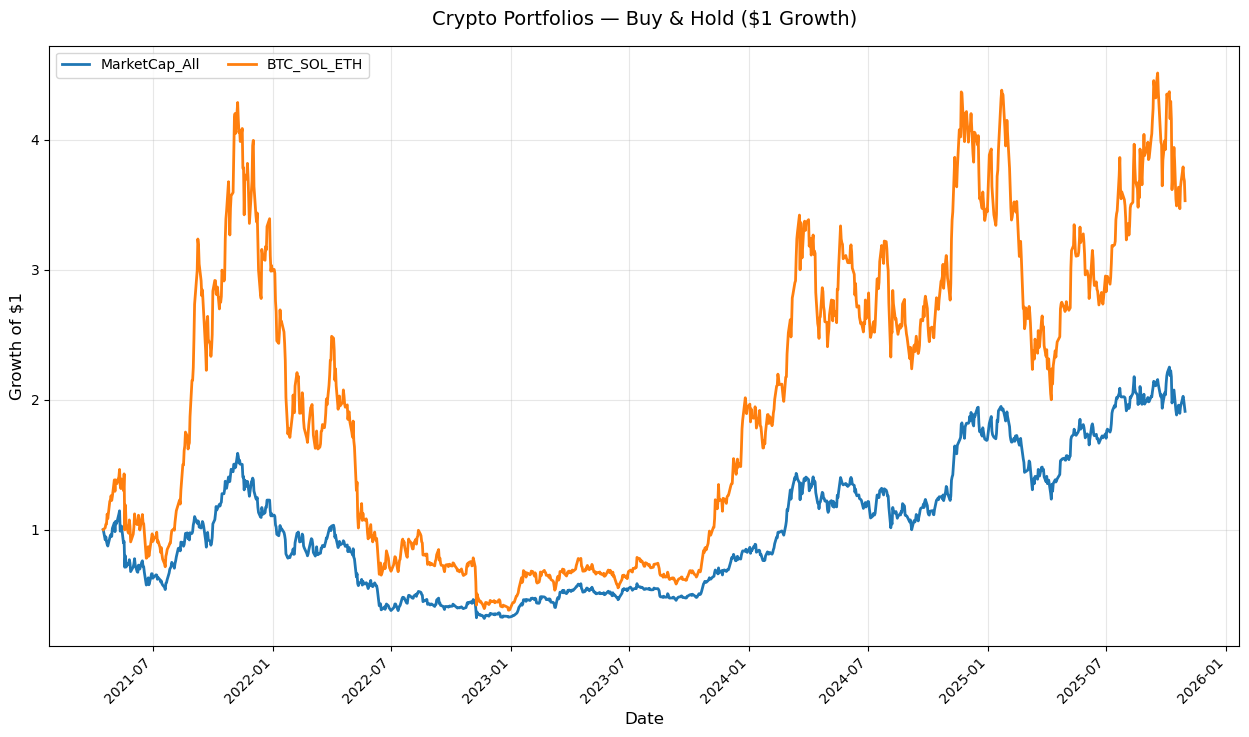

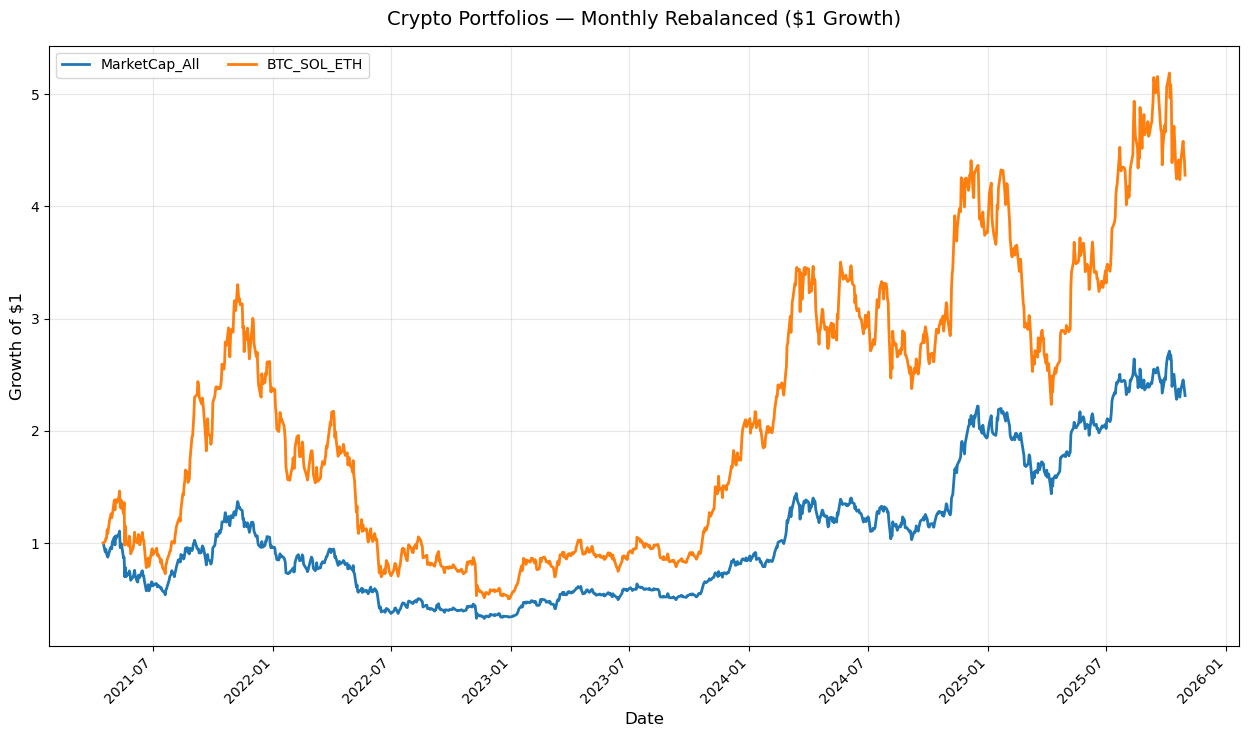

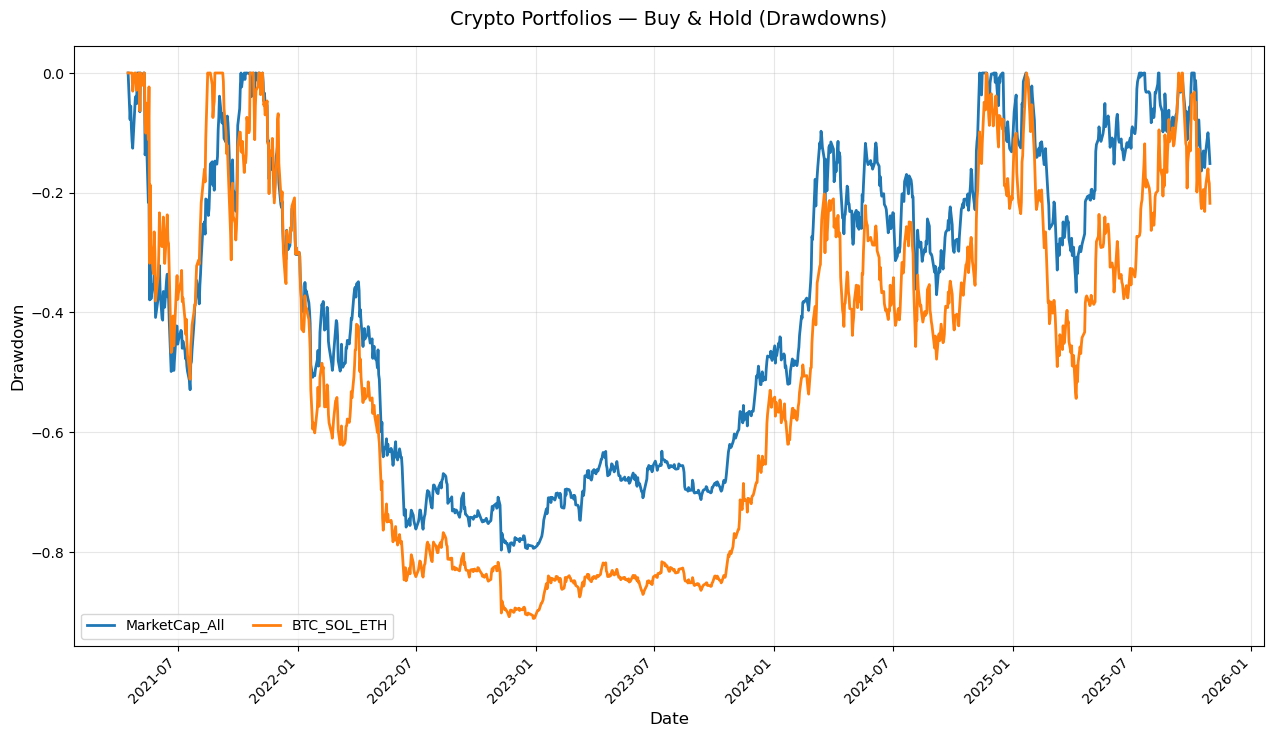

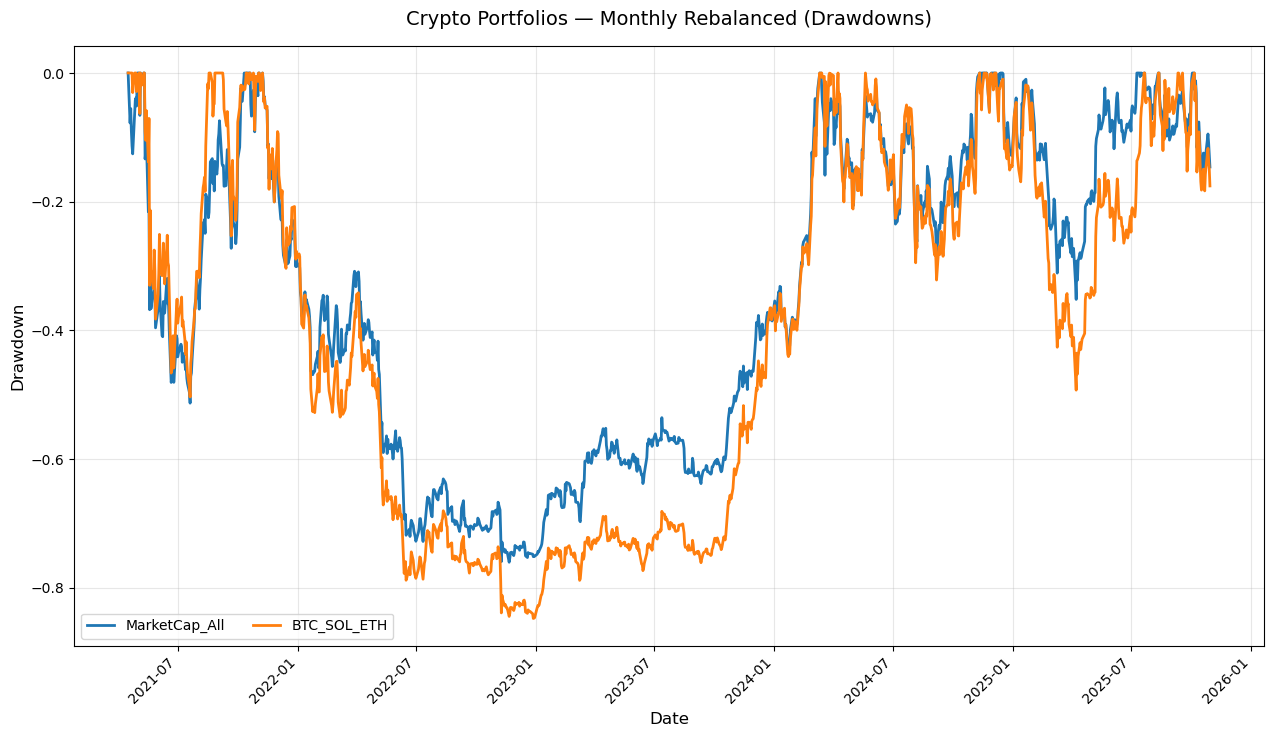

In [68]:
# Equity curves & drawdowns
def plot_equity_curves(returns_df: pd.DataFrame, title: str, fname: str):
    """Plot $1 curves for multiple series."""
    fig, ax = plt.subplots(figsize=(14, 8))
    returns_clean = returns_df.dropna(how="all")
    for c in returns_clean.columns:
        series = returns_clean[c].dropna()
        if not series.empty:
            growth = cum_growth(series)
            ax.plot(growth.index, growth.values, label=c, linewidth=2)
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_ylabel("Growth of $1", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=10, loc='best')
    # Auto-scale to fit all data
    ax.autoscale(enable=True, axis='both', tight=False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plot_and_save(fig, fname)

def plot_drawdowns(returns_df: pd.DataFrame, title: str, fname: str):
    """Plot drawdowns for multiple series."""
    fig, ax = plt.subplots(figsize=(14, 8))
    returns_clean = returns_df.dropna(how="all")
    for c in returns_clean.columns:
        series = returns_clean[c].dropna()
        if not series.empty:
            dd = drawdown_curve(series)
            ax.plot(dd.index, dd.values, label=c, linewidth=2)
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_ylabel("Drawdown", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=10, loc='best')
    # Auto-scale to fit all data
    ax.autoscale(enable=True, axis='both', tight=False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plot_and_save(fig, fname)

plot_equity_curves(port_rets_bh.dropna(how="all"), "Crypto Portfolios — Buy & Hold ($1 Growth)", "equity_curves_buyhold")
plot_equity_curves(port_rets_m.dropna(how="all"), "Crypto Portfolios — Monthly Rebalanced ($1 Growth)", "equity_curves_monthly")

plot_drawdowns(port_rets_bh.dropna(how="all"), "Crypto Portfolios — Buy & Hold (Drawdowns)", "drawdowns_buyhold")
plot_drawdowns(port_rets_m.dropna(how="all"), "Crypto Portfolios — Monthly Rebalanced (Drawdowns)", "drawdowns_monthly")


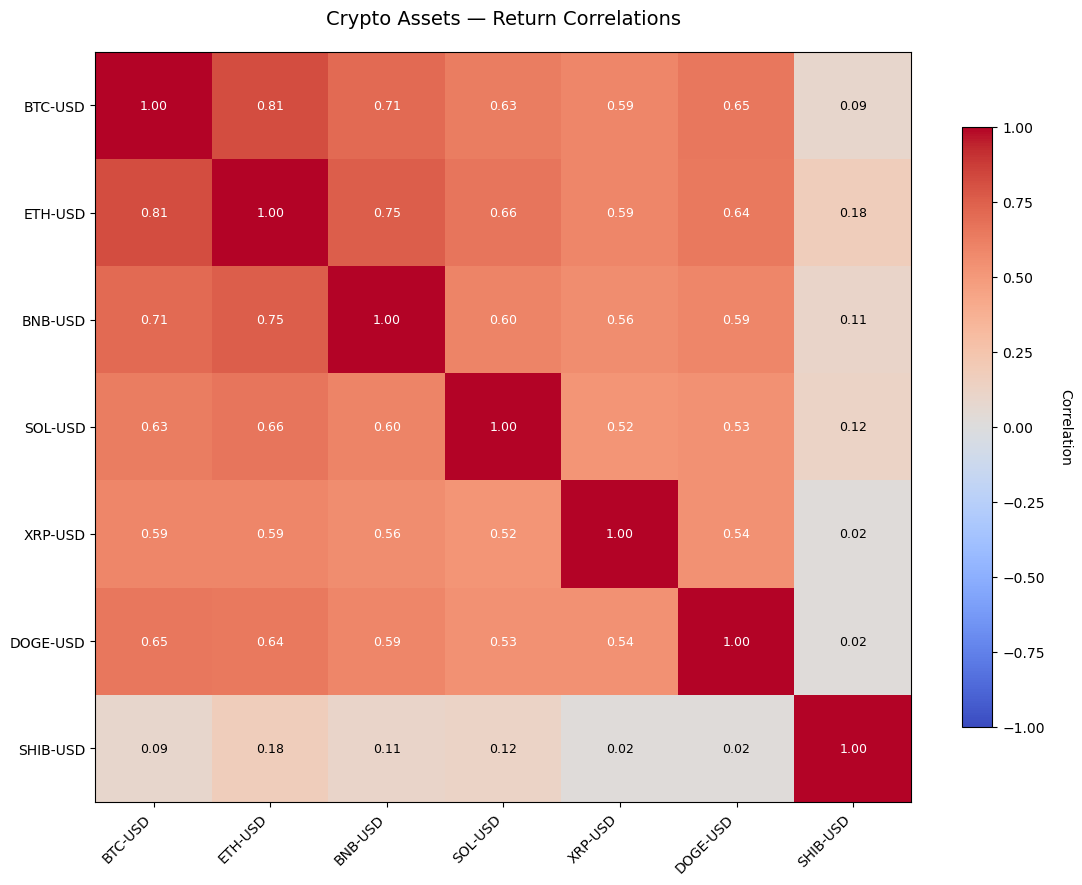

In [69]:
# Correlation heatmap of crypto assets
crypto_corr_src = crypto_rets.dropna()
if crypto_corr_src.shape[1] >= 2:
    corr_heatmap(crypto_corr_src, "Crypto Assets — Return Correlations", "corr_heatmap_crypto")


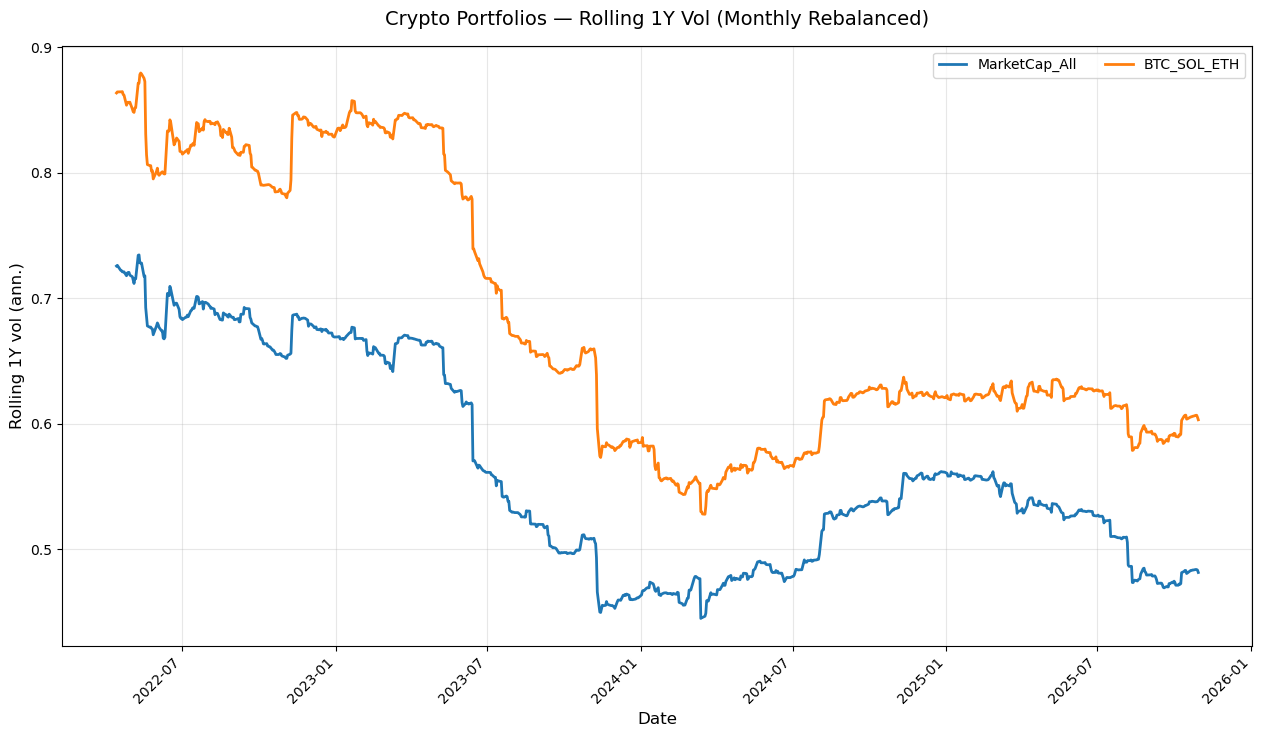

In [70]:
# Rolling volatility
def plot_rolling_vol(returns_df: pd.DataFrame, title: str, fname: str):
    """Rolling 1Y vol for multiple portfolios."""
    fig, ax = plt.subplots(figsize=(14, 8))
    returns_clean = returns_df.dropna(how="all")
    for c in returns_clean.columns:
        series = returns_clean[c].dropna()
        if not series.empty:
            roll_vol = series.rolling(ROLL_1Y).std(ddof=1) * np.sqrt(TRADING_DAYS)
            ax.plot(roll_vol.index, roll_vol.values, label=c, linewidth=2)
    ax.set_title(title, fontsize=14, pad=15)
    ax.set_ylabel("Rolling 1Y vol (ann.)", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=10, loc='best')
    # Auto-scale to fit all data
    ax.autoscale(enable=True, axis='both', tight=False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plot_and_save(fig, fname)

plot_rolling_vol(port_rets_m.dropna(how="all"), "Crypto Portfolios — Rolling 1Y Vol (Monthly Rebalanced)", "rolling_vol_monthly")


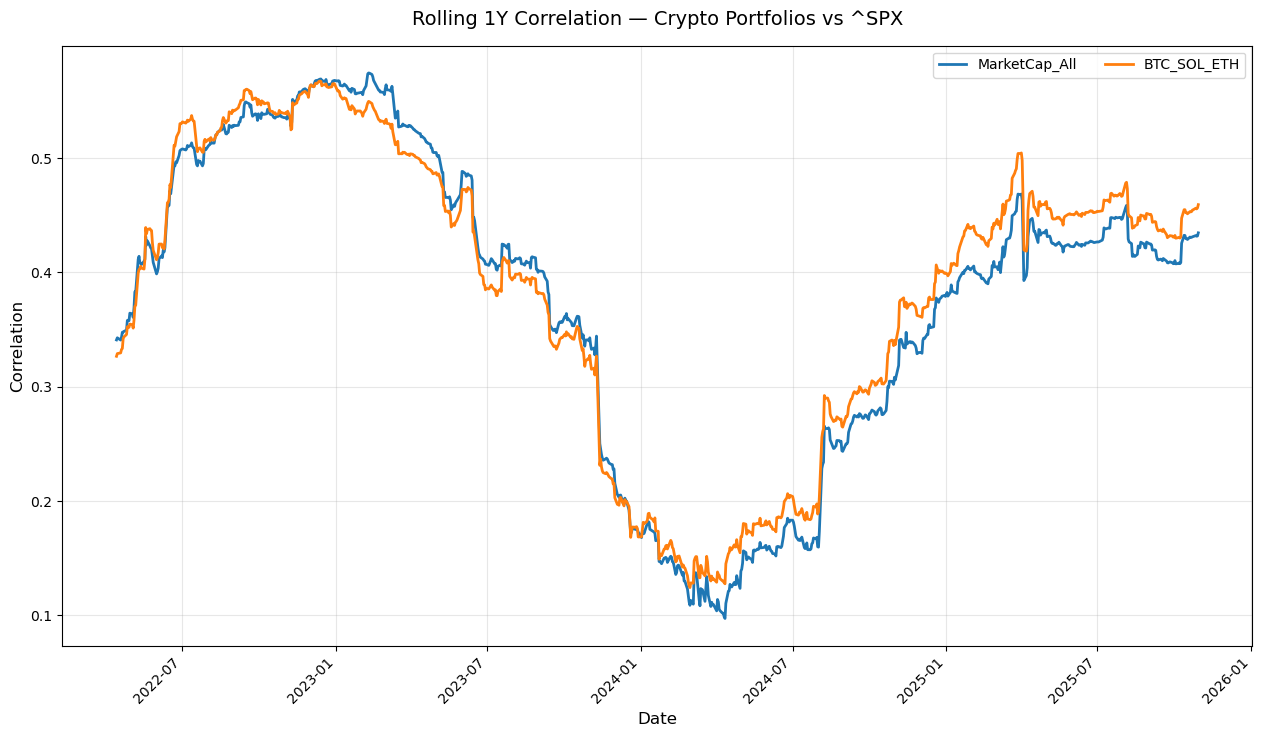

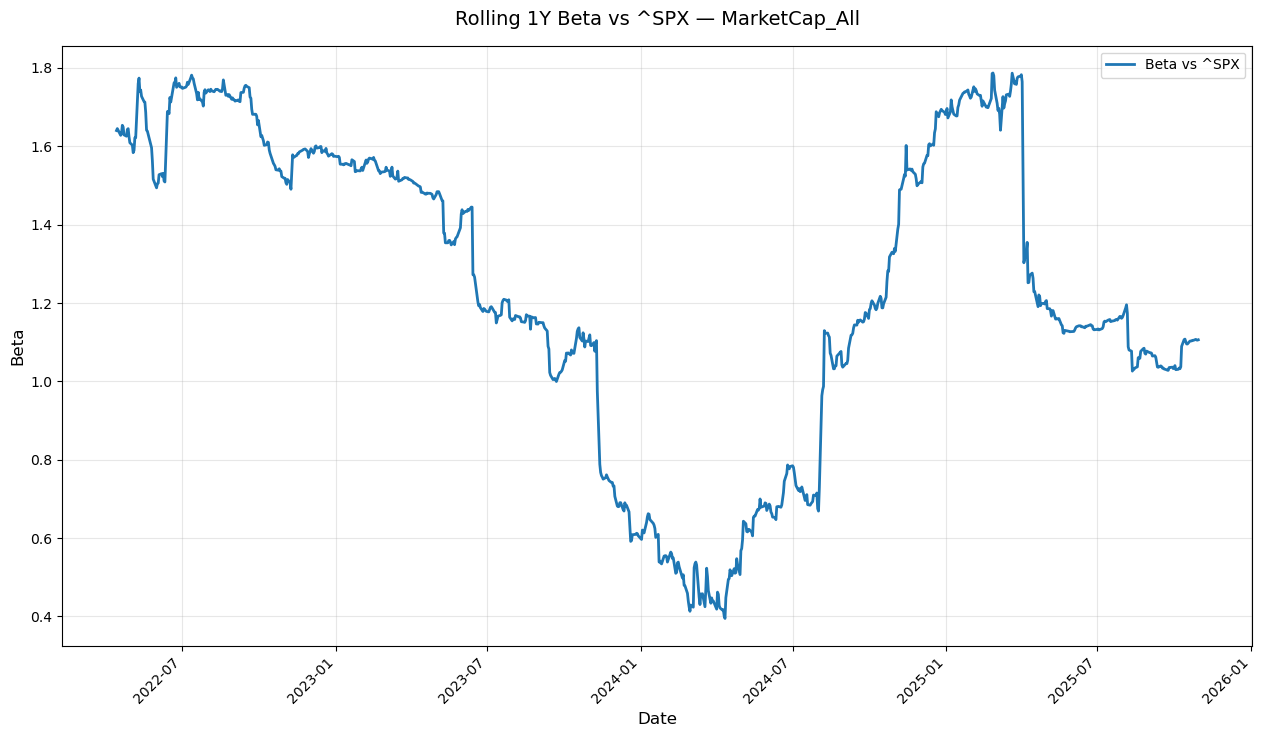

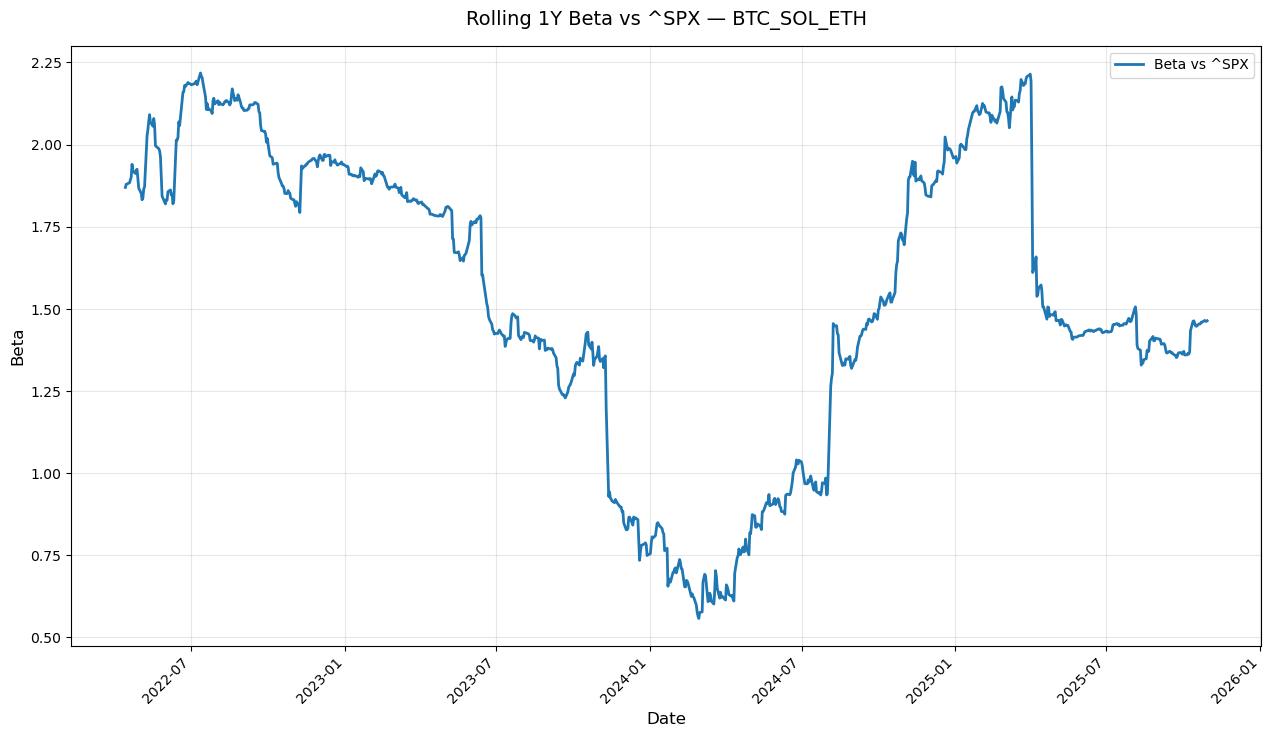

In [71]:
# Rolling betas vs SPY/SPX (using SPY/SPX as market benchmark)
# Try SPY first, then ^SPX
market_benchmark_col = None
if "^SPX" in master.columns:
    market_benchmark_col = "^SPX"
elif "SPY" in master.columns:
    market_benchmark_col = "SPY"

if market_benchmark_col:
    # Get market benchmark returns
    market_prices = master[[market_benchmark_col]].copy()
    market_rets = price_returns(market_prices)[market_benchmark_col].dropna()
    
    # Rolling correlation vs market
    fig, ax = plt.subplots(figsize=(14, 8))
    for c in port_rets_m.columns:
        dfc = pd.concat([port_rets_m[c], market_rets], axis=1).dropna()
        if dfc.shape[0] < ROLL_1Y:
            continue
        roll_corr = dfc.iloc[:, 0].rolling(ROLL_1Y).corr(dfc.iloc[:, 1])
        ax.plot(roll_corr.index, roll_corr.values, label=c, linewidth=2)
    ax.set_title(f"Rolling 1Y Correlation — Crypto Portfolios vs {market_benchmark_col}", fontsize=14, pad=15)
    ax.set_ylabel("Correlation", fontsize=12)
    ax.set_xlabel("Date", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=2, fontsize=10, loc='best')
    ax.autoscale(enable=True, axis='both', tight=False)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plot_and_save(fig, "rolling_corr_portfolios_vs_market")
    
    # Rolling betas vs market
    for c in port_rets_m.columns:
        r_port = port_rets_m[c].dropna()
        dfc = pd.concat([r_port, market_rets], axis=1).dropna()
        if dfc.shape[0] < ROLL_1Y + 50:
            continue
        
        # Get risk-free rate aligned to the common index
        rf_common = rf_aligned_m.reindex(dfc.index, fill_value=0.0)
        ex_port = dfc.iloc[:, 0] - rf_common
        ex_market = dfc.iloc[:, 1] - rf_common
        
        betas = rolling_beta_vs_benchmark(ex_port, ex_market, window=ROLL_1Y)
        
        fig, ax = plt.subplots(figsize=(14, 8))
        ax.plot(betas.index, betas.values, label=f"Beta vs {market_benchmark_col}", linewidth=2)
        ax.set_title(f"Rolling 1Y Beta vs {market_benchmark_col} — {c}", fontsize=14, pad=15)
        ax.set_ylabel("Beta", fontsize=12)
        ax.set_xlabel("Date", fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)
        ax.autoscale(enable=True, axis='both', tight=False)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        plot_and_save(fig, f"rolling_beta_vs_market_{c}")
else:
    print("Warning: No market benchmark (SPY or ^SPX) found for beta calculations")



Worst drawdown episodes (using first portfolio as reference):
         peak      trough     recover    ref_dd
0  2021-11-08  2022-11-21  2024-03-11 -0.760407
1  2021-05-11  2021-07-20  2021-10-11 -0.513129
2  2024-12-16  2025-04-08  2025-07-10 -0.351915
3  2024-03-13  2024-09-06  2024-11-11 -0.285655
4  2021-04-16  2021-04-23  2021-04-30 -0.125670


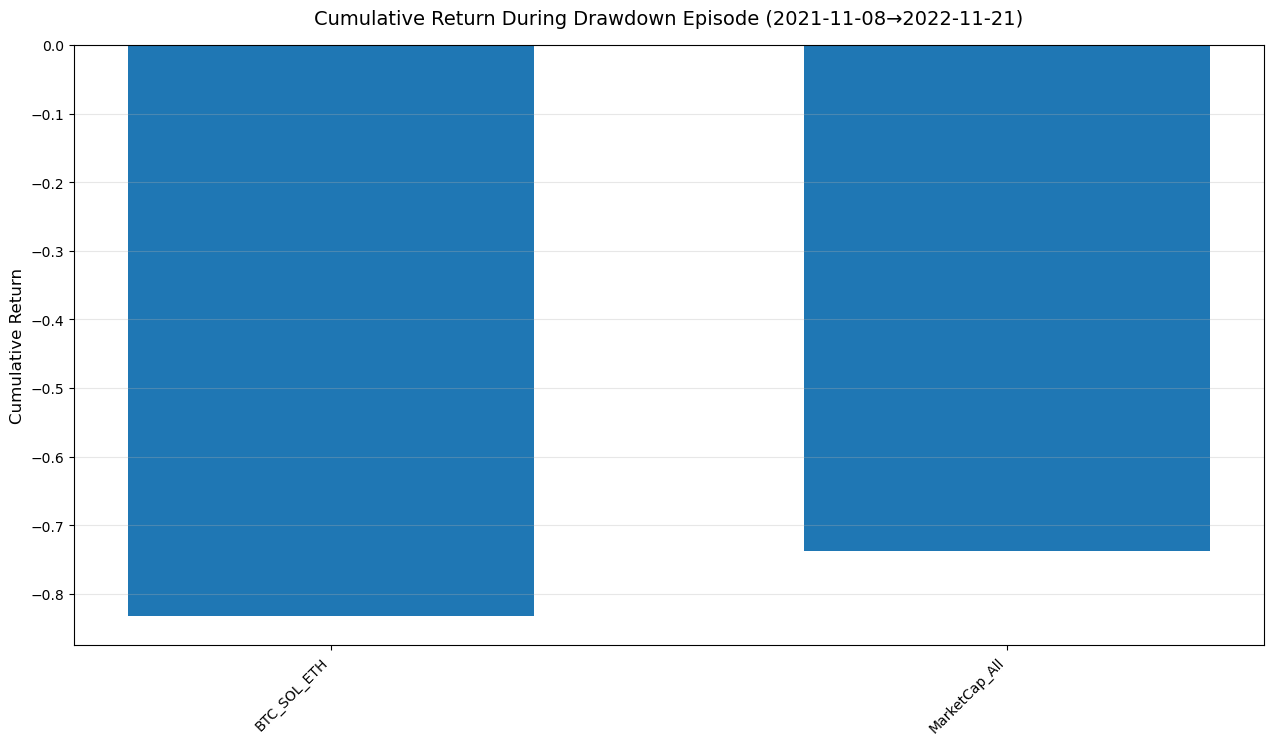

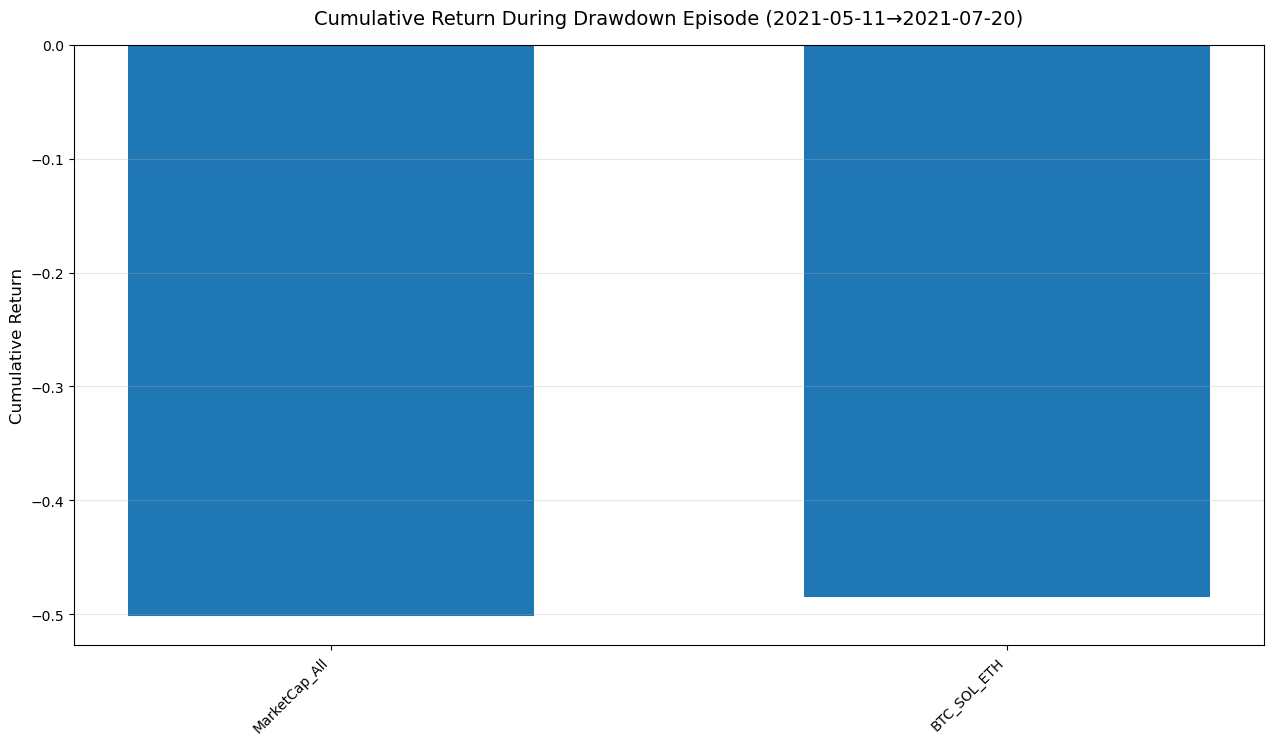

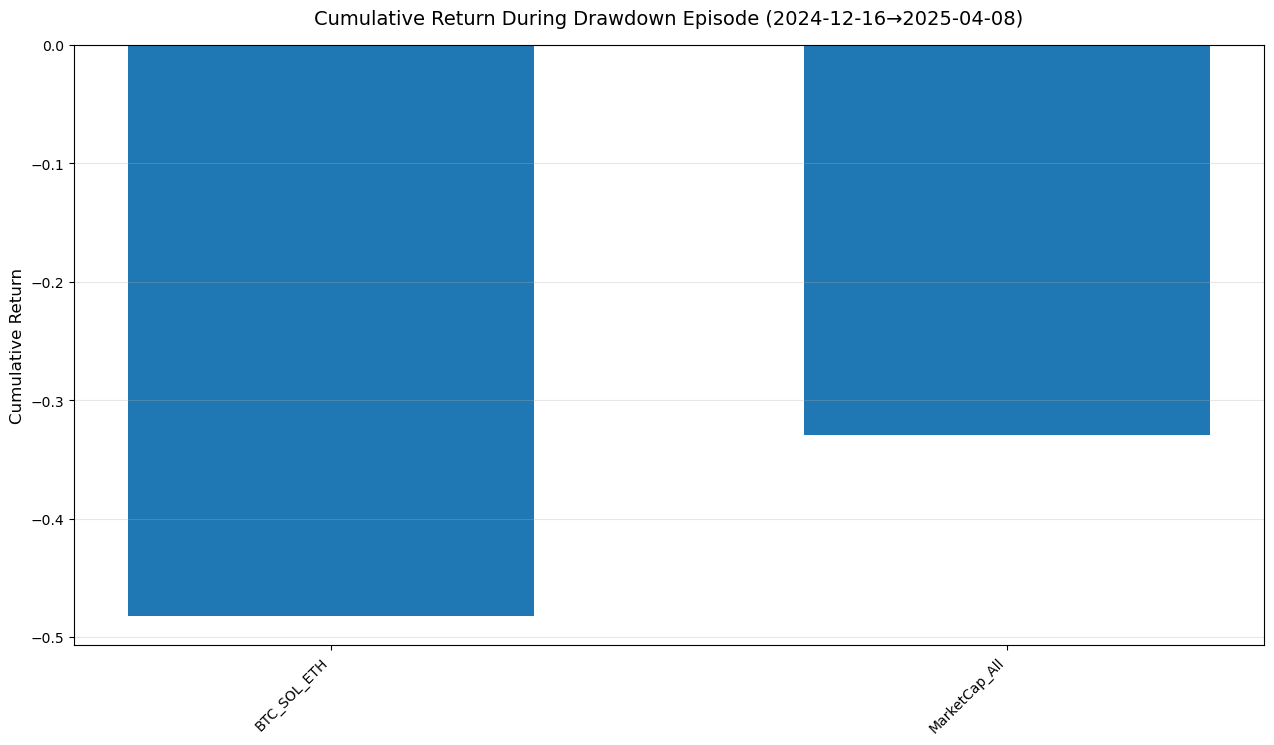

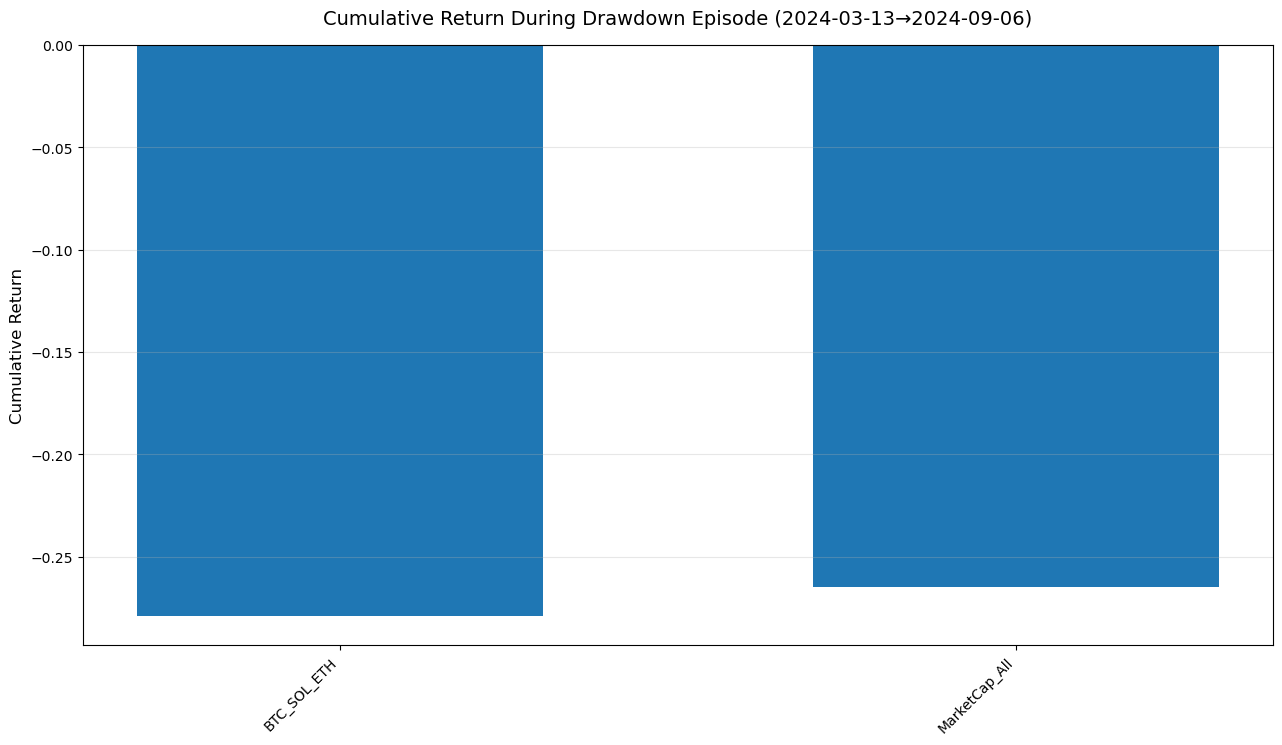

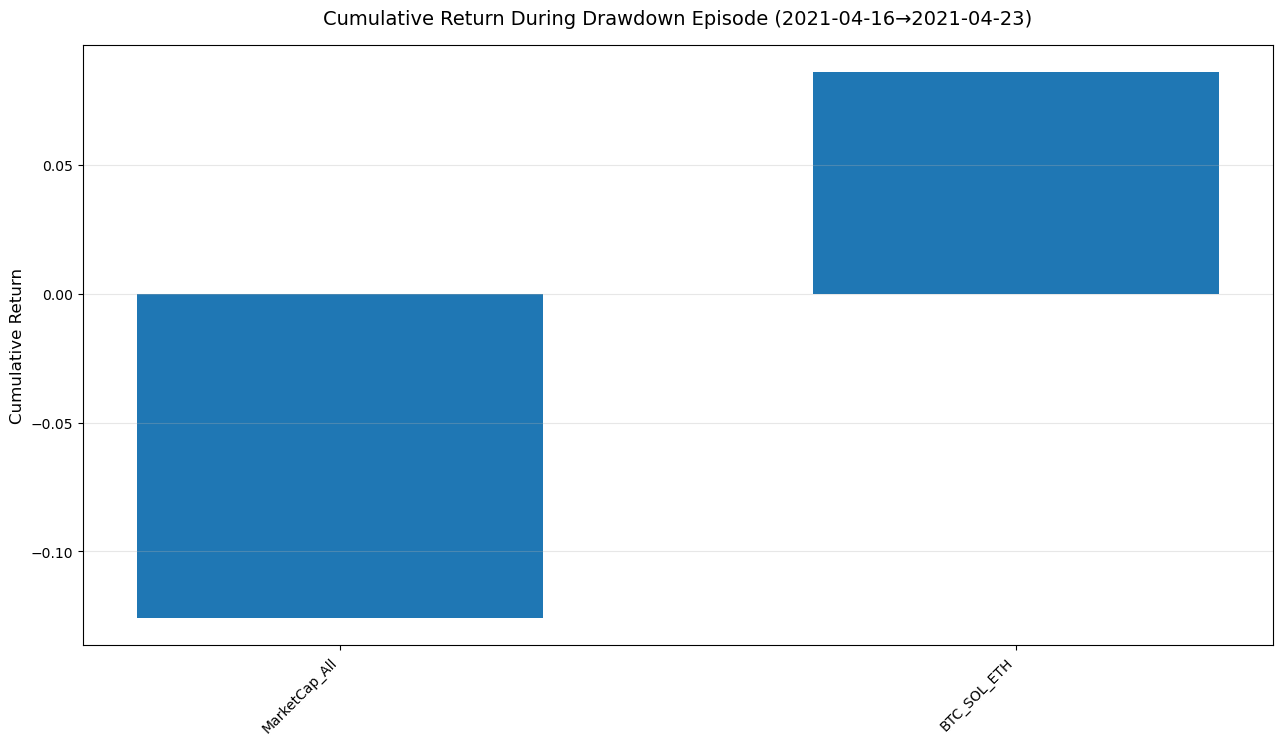

In [72]:
# Stress episodes - worst drawdown windows
# Use the first portfolio as the reference for identifying stress episodes
if len(port_rets_m.columns) > 0:
    ref_series = port_rets_m.iloc[:, 0].dropna()
    episodes = worst_drawdown_windows(ref_series, top_n=5)
    
    rows = []
    for peak_dt, trough_dt, recover_dt, dd in episodes:
        rows.append({
            "peak": peak_dt.date(),
            "trough": trough_dt.date(),
            "recover": recover_dt.date(),
            "ref_dd": dd
        })
    stress_tbl = pd.DataFrame(rows)
    stress_tbl.to_csv(os.path.join(TABLE_DIR, "worst_drawdown_episodes.csv"), index=False)
    print("\nWorst drawdown episodes (using first portfolio as reference):")
    print(stress_tbl)
    
    # Portfolio returns in those windows
    if episodes:
        stress_perf = []
        for peak_dt, trough_dt, _, dd in episodes:
            sl = slice(peak_dt, trough_dt)
            for c in port_rets_m.columns:
                rr = port_rets_m[c].loc[sl].dropna()
                if rr.empty:
                    continue
                cum = (1 + rr).prod() - 1
                stress_perf.append({
                    "episode": f"{peak_dt.date()}→{trough_dt.date()}",
                    "series": c,
                    "cum_return": cum
                })
        stress_perf = pd.DataFrame(stress_perf)
        stress_perf.to_csv(os.path.join(TABLE_DIR, "portfolio_returns_in_worst_dd_windows.csv"), index=False)
        
        # Plot each episode as a bar chart
        for ep in stress_perf["episode"].unique():
            d = stress_perf[stress_perf["episode"] == ep].sort_values("cum_return")
            fig, ax = plt.subplots(figsize=(14, 8))
            ax.bar(range(len(d)), d["cum_return"], width=0.6)
            ax.set_xticks(range(len(d)))
            ax.set_xticklabels(d["series"], rotation=45, ha='right', fontsize=10)
            ax.set_title(f"Cumulative Return During Drawdown Episode ({ep})", fontsize=14, pad=15)
            ax.set_ylabel("Cumulative Return", fontsize=12)
            ax.grid(True, alpha=0.3, axis='y')
            ax.autoscale(enable=True, axis='both', tight=False)
            plot_and_save(fig, f"stress_episode_{ep}".replace("→", "_to_").replace(":", "").replace("-", ""))
